# Gillespie Algorithm for a SIR Model with Wise and Risky Indiviuals
### by Luca Sbano (Theory & Implementation) and Steffen Bauer (Implementation & Jupyter)
***

__Definitions:__
<br>

|Variable | Meaning            |
|---------|--------------------|
|$D_1^1$: | disease 1, stage 1 |
|$D_1^2$: | disease 1, stage 2 |
|$D_2^1$: | disease 2, stage 1 |
|$D_2^2$: | disease 2, stage 2 |
|$I^1$:   | stage 1 treatment  |
|$I^2$:   | stage 2 treatment  |

__Reactions:__
<br>
$$
\begin{align}
    \empty &\rightarrow^{\lambda_1} D_1^1\\
    \empty &\rightarrow^{\lambda_2} D_2^1\\
    D_1^1 &\rightarrow^{r_1^1} D_1^2\\
    D_2^1 &\rightarrow^{r_2^1} D_2^2\\
    D_1^2 &\rightarrow^{r_1^2} \empty\\
    D_2^2 &\rightarrow^{r_2^2} \empty\\
    \empty &\rightarrow^{i^1} I^1\\
    \empty &\rightarrow^{i^2} I^2\\
    D_1^1 + I^1 &\rightarrow^{p_1^1} \empty\\
    D_2^1 + I^1 &\rightarrow^{p_2^1} \empty\\
    D_1^2 + I^2 &\rightarrow^{p_1^2} \empty\\
    D_2^2 + I^2 &\rightarrow^{p_2^2} \empty\\
\end{align}
$$

## Algorithm

1. Generate two random numbers $r_1$, $r_2$ uniformly distributed in
$[0, 1]$.
2. Compute $\mathcal{R}_0 := \sum_{j=1}^r \mathcal{R}_j$.
3. Compute $\tau := \frac{1}{\mathcal{R}_0} \ln[\frac{1}{r_1}]$.
4. If $t + \tau > T$, terminate.
4. Set time of next rule execution to $t + \tau$.
5. Compute which rule is executed at time $t + \tau$. Find $j$ such that
$$
\frac{1}{\mathcal{R}_0} \sum_{i=1}^{j-1} \mathcal{R}_i < r_2 \leq  \frac{1}{\mathcal{R}_0} \sum_{i=1}^{j} \mathcal{R}_i
$$
6. Execute rule $R_j$ and update to new system configuration.
7. Go to step 1 with updated time $t + \tau$.

# Propensities used

We have two options for modelling the influx of patients with stage 1 diseases into the model. We could have a total population size and a rate at individuals are diagnosed with the disease, and decrease the population size by one each time this happens. To reduce complexity, we will have a constant 'healthy' population size, and will model this influx as a Poisson process. Hence each of these rules have a constant propensity $\lambda_i$.

## Implementation

First load some libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
from IPython.display import display

Define the algorithm [above](#Algorithm) as a function (later used for interactivity):

In [4]:
def gillespie(lambda1   = 20, 
              lambda2   = 20, 
              r1_1      = 1, 
              r1_2      = 1,
              r2_1      = 1,
              r2_2      = 1,
              i1        = 15,
              i2        = 10,
              I1_ratio  = 0.5, 
              I2_ratio  = 0.5
             ):
    
    
    T     = 100.0           #        float; maximum elapsed time 
    t     = 0.0             #        float; start time
    
    D1_1    = 0             #        int;   initial disease 1 stage 1
    D2_1    = 0             #        int;   initial disease 1 stage 2
    D1_2    = 0             #        int;   initial disease 2 stage 1
    D2_2    = 0             #        int;   initial disease 2 stage 2
    I1      = 0             #        int;   initial stage 1 treatments
    I2      = 0             #        int;   initial stage 2 treatments
    deaths  = 0             #        int;   number of deaths
    cured   = 0             #        int;   number of people cured

    # Initialize results list
    MAXITER       = 20000
    SIR_data      = np.zeros((MAXITER, 9))

    it = 0
    # Main loop
    while t < T and it < MAXITER - 1:
        it += 1

        # Calculate propensities
        propensities = [
            lambda1,
            lambda2,
            r1_1 * D1_1,
            r1_2 * D1_2,
            r2_1 * D2_1,
            r2_2 * D2_2,
            i1,
            i2,
            I1_ratio * 100 * D1_1 * I1,
            (1 - I1_ratio) * 100 * D1_2 * I1,
            I2_ratio * 100 * D2_1 * I2,
            (1 - I2_ratio) * 100 * D2_2 * I2
        ]
        
        R0 = sum(propensities)

        # First uniformily distributed ranmdom number
        r_1 = np.random.uniform(0.0, 1.0)
        # Time increment
        dt  = -np.log(r_1) / R0
        t   = t + dt

        #Second uniformily distributed ranmdom number
        r_2 = R0 * np.random.uniform(0.0, 1.0)
    
        #Choice of the reaction according to the probabilities
        if r_2 < propensities[0]:
            D1_1 += 1
        if r_2 >= propensities[0] and r_2 < sum(propensities[0:2]):
            D1_2 += 1
        if r_2 >= sum(propensities[0:2]) and r_2 < sum(propensities[0:3]):
            D1_1 -= 1
            D2_1 += 1
        if r_2 >= sum(propensities[0:3]) and r_2 < sum(propensities[0:4]):
            D1_2 -= 1
            D2_2 += 1
        if r_2 >= sum(propensities[0:4]) and r_2 < sum(propensities[0:5]):
            D2_1 -= 1
            deaths += 1
        if r_2 >= sum(propensities[0:5]) and r_2 < sum(propensities[0:6]):
            D2_2 -= 1
            deaths += 1
        if r_2 >= sum(propensities[0:6]) and r_2 < sum(propensities[0:7]):
            I1 = min(I1 + 1, 3)
        if r_2 >= sum(propensities[0:7]) and r_2 < sum(propensities[0:8]):
            I2 = min(I2 + 1, 3)
        if r_2 >= sum(propensities[0:8]) and r_2 < sum(propensities[0:9]):
            I1 -= 1
            D1_1 -= 1
            cured += 1
        if r_2 >= sum(propensities[0:9]) and r_2 < sum(propensities[0:10]):
            I1 -= 1
            D1_2 -= 1
            cured += 1
        if r_2 >= sum(propensities[0:10]) and r_2 < sum(propensities[0:11]):
            I2 -= 1
            D2_1 -= 1
            cured += 1
        if r_2 >= sum(propensities[0:11]):
            I2 -= 1
            D2_2 -= 1
            cured += 1
        
        
        #print("{:f} \t {:d} \t {:d} \t {:d} \t {:d} \t {:d}".format(t, n_W, n_I, n_R, n_S, n_D))
        SIR_data[it, :] = [t, D1_1, D2_1, D1_2, D2_2, I1, I2, deaths, cured]

    #Plotting
    SIR     = SIR_data[:it,:]
    time    = SIR[:,0]
    D1_1    = SIR[:,1]
    D2_1    = SIR[:,2]
    D1_2    = SIR[:,3]
    D2_2    = SIR[:,4]
    I1      = SIR[:,5]
    I2      = SIR[:,6]
    deaths  = SIR[:,7]
    cured   = SIR[:,8]

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), nrows = 3, sharex = True, constrained_layout = True)

    line1, = ax1.plot(time,D1_1, label='$D^1_1$')
    line2, = ax1.plot(time,D2_1, label='$D^2_1$')
    #line5, = ax1.plot(time,I1, label='$I^1$')
    #line6, = ax1.plot(time,I2, label='$I^2$')
    
    legend1 = ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
    ax1.set_xlim(0., T)
    ax1.set_title('Disease 1')
    ax1.set_ylabel('Individuals')
    

    line3, = ax2.plot(time,D1_2, label='$D^1_2$')
    line4, = ax2.plot(time,D2_2, label='$D^2_2$')
    legend2 = ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
    ax2.set_xlim(0., T)
    ax2.set_title('Disease 2')
    ax2.set_ylabel('Individuals')

    line7, = ax3.plot(time, deaths, label='Deaths')
    line8, = ax3.plot(time, cured, label='Cured')

    legend3 = ax3.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
    ax3.set_xlim(0., T)
    ax3.set_title(f'Cured {100 * cured[-1] / (deaths[-1] + cured[-1]):.0f}% of patients')
    ax3.set_ylabel('Individuals')

    plt.xlabel('time')

    plt.show()

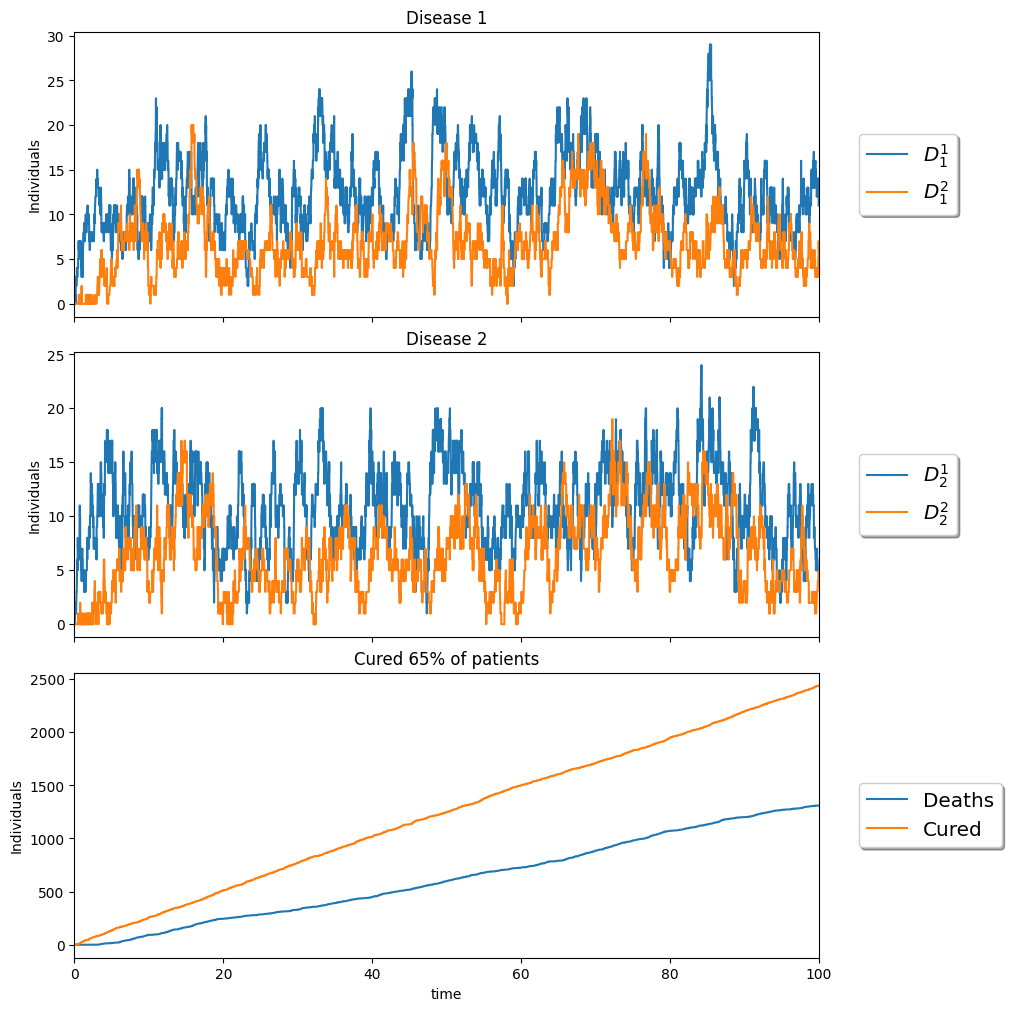

In [5]:
gillespie()

You could call the function simply by 
`gillespie()` or `gillespie(rWiseToRisky = 0.8)` if you want to chance the parameters / reaction rates.

But we can add interactivity by simply using `interact(function, paramters = (min, max, stepsize))`. And we get some lovely sliders.

_(Please, be patient and wait for updating of the graph.)_

In [6]:
interact(
    gillespie,
    lambda1   = (10, 30, 1),
    lambda2   = (10, 30, 1),
    r1_1      = (0.,10.,0.5), 
    r1_2      = (0.,10.,0.5),
    r2_1      = (0.,10.,0.5),
    r2_2      = (0.,10.,0.5),
    i1        = (0,20,1),
    i2        = (0,20,1),
    I1_ratio  = (0.,1.,0.1),
    I2_ratio  = (0.,1.,0.1)
)

interactive(children=(IntSlider(value=20, description='lambda1', max=30, min=10), IntSlider(value=20, descript…

<function __main__.gillespie(lambda1=20, lambda2=20, r1_1=1, r1_2=1, r2_1=1, r2_2=1, i1=15, i2=10, I1_ratio=0.5, I2_ratio=0.5)>

# To Do
1. Policy rates need to be much higher
2. split cured, deaths by disease
3. add mass action equations